## jupyter notebook for writing run + dashboarding funcs

Author: Eric Wu <br>
Date: 11.23.2025

## Contents
0. [Import Dependencies](#0-import-dependencies)
1. [Initialize Realm](#1-initialize-realm)
1. [Run EvolveMM](#3-run-evolvemm)
    - [mm_employee_master Delta Report](#31-evolvemm-with-an-interupt-to-check-mm_employee_master-deltas)
1. [Check Outputs](#4-check-outputs)

### 0. Import Dependencies

In [1]:
import numpy as np 
import pandas as pd
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_rows', 100)
import sys
import time
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

In [2]:
mydir = '/Users/eric/Documents/CDS465/' ### ADJUST FILEPATH

pysrc = mydir + 'pysrc/'
datadir = mydir + 'data/'
popdir = mydir + 'population/'
folderpath = mydir + 'archieve/Dev_P1/BASE_DATA/' ###set folderpath

sys.path.append( pysrc )
import Main2
import island

import initialization as initf
import operations as ops

### 1. Initialize Realm

In [3]:
E = Main2.Realm(datadir)
E.ReadAll(popdir + 'pop3_7.db') ### ADJUST NAME
E.loc_gen_dict = {'farming': (5,12,5),'mining': (5,16,10),'energy': (0,50,20),'manufacturing': (5,100,50)} #set params
E.folderpath = folderpath #set params
E.InitializeMM()
#E.initfQuickLook(5)

Population started at 8320. 
Need to evolve 8 months before initialization for parity with accounting periods. 
initializing...


### 3. Run EvolveMM

In [4]:
#EvolveMM(Nmonths, addpeep, dometh, migrate=False)
E.mm_params['n_orders'] = 100
E.mm_params['xbar_order_size'] = 250


t_b = time.perf_counter()
nmonths = 12*10
E.EvolveMM(nmonths,5,0,False)
t_e = time.perf_counter()

print(f'Total time for evolving {nmonths} months was {(t_e-t_b):.4f} seconds')

Total added time due to operations was 20.939132092084037 seconds. 
Total time due to Evolve was 149.62383454501105 seconds.
Total time for evolving 120 months was 170.5665 seconds


#### 3.1 EvolveMM with an interupt to check mm_employee_master Deltas

In [5]:
def create_delta_report(df_old: pd.DataFrame, df_new: pd.DataFrame, key_column: str) -> pd.DataFrame:
    """
    Compares two DataFrames to create a delta report showing added, deleted,
    and modified rows.
    """
    # Set the unique key as the index for alignment
    df_old_indexed = df_old.set_index(key_column).sort_index()
    df_new_indexed = df_new.set_index(key_column).sort_index()

    # Get indices of rows only in the new DF (Added)
    added_index = df_new_indexed.index.difference(df_old_indexed.index)
    df_added = df_new_indexed.loc[added_index].copy()
    df_added['Change_Type'] = 'Added'

    # Get indices of rows only in the old DF (Deleted)
    deleted_index = df_old_indexed.index.difference(df_new_indexed.index)
    df_deleted = df_old_indexed.loc[deleted_index].copy()
    df_deleted['Change_Type'] = 'Deleted'
    
    # Get indices of rows present in both (Common)
    common_index = df_new_indexed.index.intersection(df_old_indexed.index)
    df_common_old = df_old_indexed.loc[common_index]
    df_common_new = df_new_indexed.loc[common_index]

    # Use .compare() to find differences in common rows
    # Keep only rows where a difference was found (i.e., drop rows with all NaN columns)
    df_modified = df_common_old.compare(df_common_new, align_axis=1, result_names=('Old', 'New'))
    df_modified = df_modified.dropna(axis=0, how='all')
    
    if not df_modified.empty:
        # Flatten the MultiIndex columns and add a Change_Type column
        # Example: ('Price', 'Old') becomes 'Price_Old'
        df_modified.columns = [f'{col[0]}_{col[1]}' for col in df_modified.columns]
        df_modified['Change_Type'] = 'Modified'
        
        # Bring the 'Modified' change type column to the front
        cols = ['Change_Type'] + [col for col in df_modified.columns if col != 'Change_Type']
        df_modified = df_modified[cols]
    
    # Align columns for added/deleted before concatenation
    all_reports = [df_added, df_deleted]
    
    # Only include modified if there are actual changes
    if not df_modified.empty:
        all_reports.append(df_modified.reset_index(names=key_column))
    
    # For a clean final view, stack the added and deleted reports first
    final_report = pd.concat(all_reports, ignore_index=False)
    
    # For Added/Deleted rows, move the key column from index to a regular column
    df_added_deleted = final_report[final_report['Change_Type'].isin(['Added', 'Deleted'])].reset_index(names=key_column)
    
    # Combine the Added/Deleted and Modified results
    df_final = pd.concat([df_added_deleted, df_modified.reset_index(names=key_column)[df_modified.columns.insert(0, key_column)]], ignore_index=True)
    
    # Sort the results by the key column and change type
    df_final = df_final.sort_values(by=[key_column, 'Change_Type']).reset_index(drop=True)
    
    return df_final

#EvolveMM(Nmonths, addpeep, dometh, migrate=False)
E.mm_params['n_orders'] = 100
E.mm_params['xbar_order_size'] = 250

nmonths = 12*50
t_b = time.perf_counter()
for month in range(nmonths):
    emp_old = E.mm_dfs['mm_employee_master'].copy()
    E.EvolveMM(1,5,0,False)
    emp_new = E.mm_dfs['mm_employee_master'].copy()
    
    print(f'At month {E.month} the deltas in employee master are')
    print(create_delta_report(emp_old, emp_new,'pid'))
    
t_e = time.perf_counter()
print(f'Total time for evolving {nmonths} months was {(t_e-t_b):.4f} seconds')

### 4. Check outputs

In [6]:
E.mm_dfs['mm_order_master'].groupby('order_date')['order_id'].count().reset_index().tail()

,order_date,order_id
115,8443,100
116,8444,100
117,8445,100
118,8446,100
119,8447,100


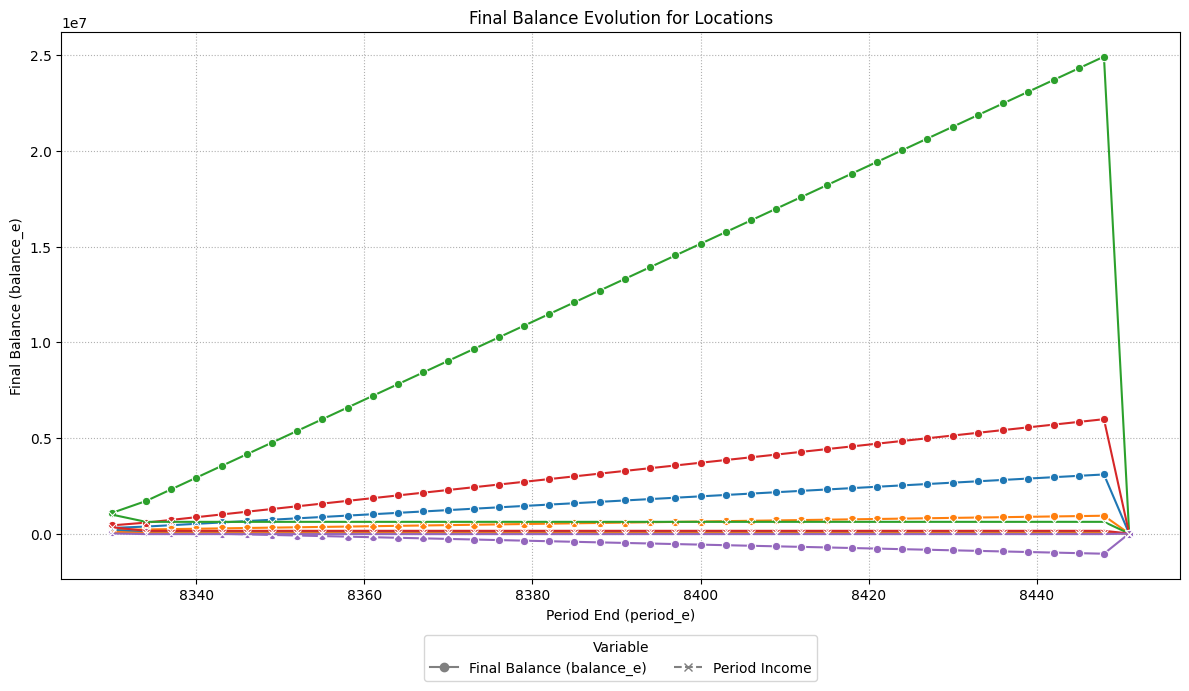

In [7]:
df_books = E.mm_dfs['mm_books'].copy()

# Select a few locations to keep the plot readable (e.g., the top 5 by latest balance)
latest_period = df_books['period_e'].max()
top_locations = df_books[df_books['period_e'] == latest_period].nlargest(5, 'balance_e')['location_coord']

df_tracking = df_books[df_books['location_coord'].isin(top_locations)]

plt.figure(figsize=(12, 7))
sns.lineplot(
    data=df_tracking,
    x='period_e',
    y='balance_e',
    hue='location_coord',
    marker='o'
)
sns.lineplot(
    data=df_tracking,
    x='period_e',
    y='period_income',
    hue='location_coord',
    marker='x'
)
legend_handles = [
    plt.Line2D([0], [0], color='gray', linestyle='-', marker='o', label='Final Balance (balance_e)'),
    plt.Line2D([0], [0], color='gray', linestyle='--', marker='x', label='Period Income')
]
plt.legend(handles=legend_handles, title='Variable', loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=2)

plt.yscale('linear')
plt.title('Final Balance Evolution for Locations')
plt.xlabel('Period End (period_e)')
plt.ylabel('Final Balance (balance_e)')
plt.grid(True, linestyle=':')
plt.tight_layout()
plt.show()

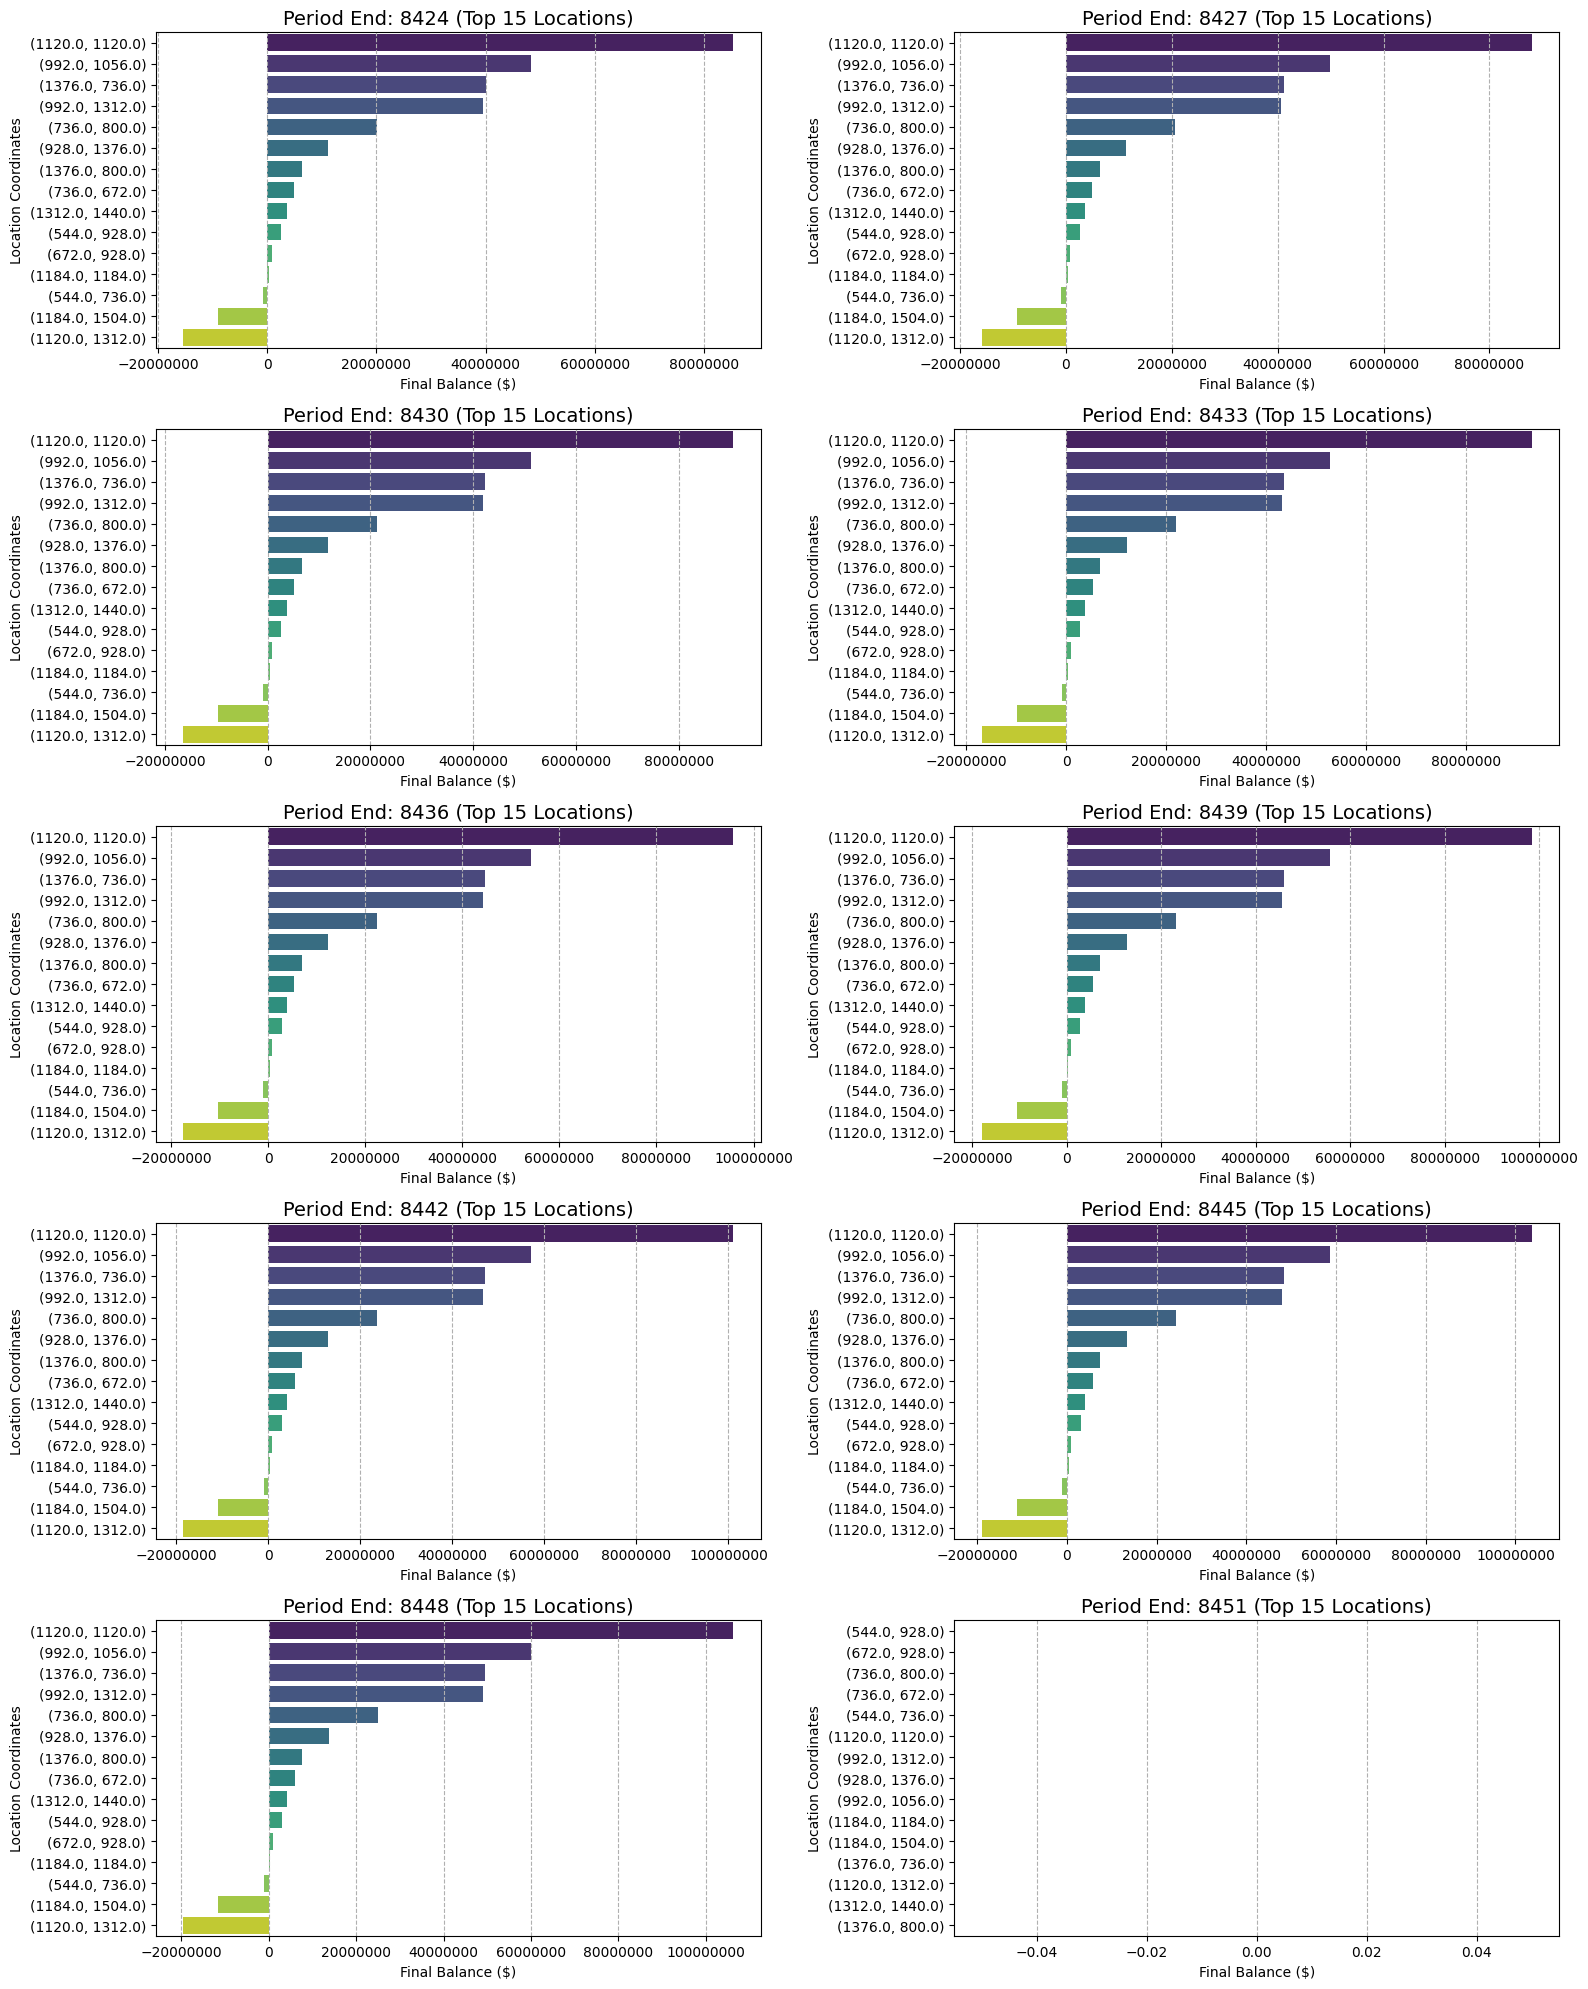

In [8]:
def plot_balance_by_period(df, top_n=10, num_periods_to_show=4):
    """
    Generates a separate bar plot for the final balance for the top N locations
    for the last 'num_periods_to_show' unique periods.
    """
    # Find the unique periods and select the latest ones
    unique_periods = df['period_e'].sort_values(ascending=True).unique()
    periods_to_plot = unique_periods[-num_periods_to_show:]

    # Determine the number of rows and columns for the subplot grid
    # Use 2 columns max for better readability
    n_cols = min(len(periods_to_plot), 2)
    n_rows = (len(periods_to_plot) + n_cols - 1) // n_cols

    # Create the figure and axes
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(8 * n_cols, 4 * n_rows))
    
    # Ensure axes is always iterable
    if n_rows * n_cols == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    for i, period in enumerate(periods_to_plot):
        # Filter data for the current period
        df_period = df[df['period_e'] == period].copy()

        # Convert location_coord to string to avoid ValueError
        df_period['location_coord'] = df_period['location_coord'].astype(str)

        # Sort and select top N locations based on balance_e
        df_period_sorted = df_period.nlargest(top_n, 'balance_e')

        # Use the current axis
        ax = axes[i]

        # Generate the bar plot
        sns.barplot(
            x='balance_e',
            y='location_coord',
            data=df_period_sorted,
            palette='viridis',
            ax=ax
        )

        ax.set_title(f'Period End: {period} (Top {top_n} Locations)', fontsize=14)
        ax.set_xlabel('Final Balance ($)')
        #ax.ticklabel_format(style='plain', axis='y', useOffset=False)
        #ax.yaxis.set_major_locator(mticker.MaxNLocator(nbins=6, prune='lower'))
        ax.set_ylabel('Location Coordinates')
        # Display large numbers cleanly without scientific notation
        ax.ticklabel_format(style='plain', axis='x', useOffset=False)
        ax.xaxis.grid(True, linestyle='--')

    # Remove any unused subplots
    for j in range(len(periods_to_plot), n_rows * n_cols):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

# You would call this function with your DataFrame:
plot_balance_by_period(E.mm_dfs['mm_books'], top_n=15, num_periods_to_show=10)

## Reporting Functions

In [11]:
import functools

In [ ]:
def mm_save(realmc: Main2):
    """
    This function saves all the mm_dfs to a .xlsx file 
    """
    with pd.ExcelWriter(realmc.folderpath + 'mm_dfs.xlsx') as writer:
        for dfname, df in realmc.mm_dfs.items():
            df.to_excel(writer, sheet_name=dfname, index=False)

### Write dashboarding function

KPIs:

OTD: On time deliveries <br>
Cycle Time<br>
Throughput: The total amount of product produced over a specific period<br>
Cost Per Unit:<br>
Manufacturing Cost: <br>
Employee Turnover:<br>
Backlog:<br>

In [14]:
E.mm_dfs['qa_sandbox_orders'].head(10)

,order_id,product_id,product_quantity,order_date,ship_to,ship_by,account_receivable,order_status
0,o000001,p000307,505,8328,qa_simulate_orders,8329,12625.00,1
1,o000002,p000116,541,8328,qa_simulate_orders,8330,243450.00,2
2,o000003,p000319,481,8328,qa_simulate_orders,8330,288600.00,2
3,o000004,p000428,266,8328,qa_simulate_orders,8329,1064.00,1
4,o000005,p000010,722,8328,qa_simulate_orders,8329,50540.00,1
5,o000006,p000322,553,8328,qa_simulate_orders,8330,414750.00,2
6,o000007,p000007,656,8328,qa_simulate_orders,8329,32800.00,1
7,o000008,p000001,648,8328,qa_simulate_orders,8329,22680.00,1
8,o000009,p000001,414,8328,qa_simulate_orders,8329,14490.00,1
9,o000010,p000428,664,8328,qa_simulate_orders,8329,2656.00,1


In [ ]:
def mm_report(realmc: Main2, **kwags) -> None:
    """
    This function generates reports given kwags
    """
    pass

### Write run function

In [ ]:
def mm_run(params: dict):
    """
    This function runs an instance of realm with 
    """